In [ ]:
! nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
! nvidia-smi

Sun Dec  8 23:22:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! pip install gpytorch

Streaming output truncated to the last 5000 lines.
Iteration 1/5000 - Loss: 1688.142
Iteration 2/5000 - Loss: 1495.723
Iteration 3/5000 - Loss: 1394.425
Iteration 4/5000 - Loss: 1342.695
Iteration 5/5000 - Loss: 1228.090
Iteration 6/5000 - Loss: 1172.429
Iteration 7/5000 - Loss: 1104.868
Iteration 8/5000 - Loss: 1020.230
Iteration 9/5000 - Loss: 961.600
Iteration 10/5000 - Loss: 920.457
Iteration 11/5000 - Loss: 867.466
Iteration 12/5000 - Loss: 824.040
Iteration 13/5000 - Loss: 788.289
Iteration 14/5000 - Loss: 752.157
Iteration 15/5000 - Loss: 721.222
Iteration 16/5000 - Loss: 695.694
Iteration 17/5000 - Loss: 668.781
Iteration 18/5000 - Loss: 642.394
Iteration 19/5000 - Loss: 620.192
Iteration 20/5000 - Loss: 601.880
Iteration 21/5000 - Loss: 582.103
Iteration 22/5000 - Loss: 564.506
Iteration 23/5000 - Loss: 550.873
Iteration 24/5000 - Loss: 536.803
Iteration 25/5000 - Loss: 521.250
Iteration 26/5000 - Loss: 507.025
Iteration 27/5000 - Loss: 496.109
Iteration 28/5000 - Loss: 484.63

/usr/local/lib/python3.10/dist-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Root Mean Squared Error (RMSE): 55.390
R^2 Score: -0.469


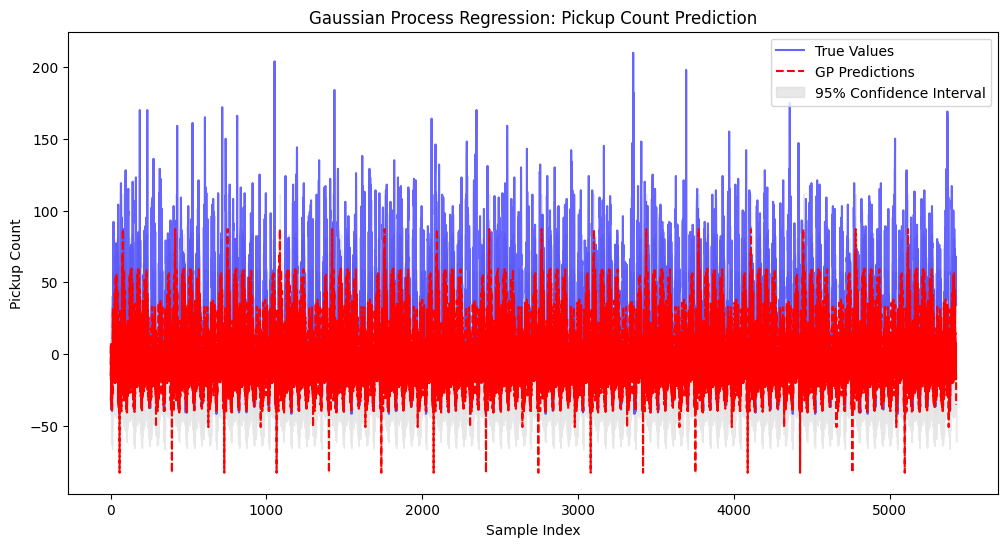

In [1]:
import cudf  # GPU-accelerated DataFrame library
import cupy as cp  # GPU-based numerical computations
import torch  # PyTorch for GPU-accelerated tensor operations
import gpytorch  # GPyTorch for Gaussian Process Regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import os

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the path to your Google Drive folder
GOOGLE_DRIVE_PATH = 'drive/My Drive/PTSA/raw_data'

# Correctly join the path to the 'train.csv' file
train_csv = os.path.join(GOOGLE_DRIVE_PATH, 'train.csv')
test_csv = os.path.join(GOOGLE_DRIVE_PATH, 'test.csv')

# Load the training data using cuDF
train = cudf.read_csv(train_csv)
test = cudf.read_csv(test_csv)

# Load training data using cuDF
# train = cudf.read_csv('./processed_data/train.csv')
train['tip_amount'] = train['tip_amount'].fillna(0)
train['pickup_count'] = train['pickup_count'].fillna(0)  # Ensure no nulls in target column
train['tpep_pickup_datetime'] = cudf.to_datetime(train['tpep_pickup_datetime'])
train = train.set_index('tpep_pickup_datetime')

# Add interval and time index columns
train['interval'] = cp.arange(1, len(train) + 1) % 48  # Get to hour interval
train['time_index'] = cp.arange(1, len(train) + 1)

# Limit to first 800 rows for training (convert to pandas for preview if needed)
train = train.iloc[:8000]
print(train.head().to_pandas())  # Convert to pandas for display

# Load testing data using cuDF
# test = cudf.read_csv('./processed_data/test.csv')
test['tip_amount'] = test['tip_amount'].fillna(0)
test['pickup_count'] = test['pickup_count'].fillna(0)  # Ensure no nulls in target column
test['tpep_pickup_datetime'] = cudf.to_datetime(test['tpep_pickup_datetime'])
test = test.set_index('tpep_pickup_datetime')

# Add interval and time index columns
test['interval'] = cp.arange(1, len(test) + 1) % 48  # Get to hour interval
test['time_index'] = cp.arange(1, len(test) + 1)

# Limit to first 800 rows for testing (convert to pandas for preview if needed)
test = test.iloc[:8000]
print(test.head().to_pandas())  # Convert to pandas for display

# Features (X) - All columns except 'pickup_count'
X_train = train[['interval', 'weekday']].to_cupy()  # Convert cuDF to CuPy array
X_test = test[['interval', 'weekday']].to_cupy()    # Convert cuDF to CuPy array

# Target (y) - 'pickup_count'
mean_func = train['pickup_count'].mean()
y_train = train['pickup_count'].to_cupy() - mean_func  # Center target variable
y_test = test['pickup_count'].to_cupy() - mean_func

# Scale features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(cp.asnumpy(X_train))  # Convert CuPy array to NumPy for scaling
X_test_scaled = scaler.transform(cp.asnumpy(X_test))       # Convert CuPy array to NumPy for scaling

# Convert scaled features back to PyTorch tensors for GPU processing
X_train_torch = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_torch = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).to(device)

# Define the GP model using GPyTorch
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel() +
            gpytorch.kernels.PeriodicKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Define the likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
model = ExactGPModel(X_train_torch, y_train_torch, likelihood).to(device)

# Set the model in training mode
model.train()
likelihood.train()

# Use the Adam optimizer (gradient-based optimization)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Loss function: Marginal Log Likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Training loop
num_iterations = 5000  # Number of optimization iterations
for i in range(num_iterations):
    optimizer.zero_grad()
    output = model(X_train_torch)
    loss = -mll(output, y_train_torch)  # Negative log likelihood
    loss.backward()
    print(f"Iteration {i + 1}/{num_iterations} - Loss: {loss.item():.3f}")
    optimizer.step()

# Set the model in evaluation mode for predictions
model.eval()
likelihood.eval()

# Make predictions on test data
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(X_test_torch))
    mean_pred = predictions.mean.cpu().numpy()  # Move results back to CPU for evaluation
    lower, upper = predictions.confidence_region()
    lower = lower.cpu().numpy()
    upper = upper.cpu().numpy()

# Evaluate the model's performance
rmse = mean_squared_error(cp.asnumpy(y_test), mean_pred, squared=False)
r2 = r2_score(cp.asnumpy(y_test), mean_pred)
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"R^2 Score: {r2:.3f}")

# Visualization of predictions with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), cp.asnumpy(y_test), label="True Values", color="blue", alpha=0.6)
plt.plot(range(len(mean_pred)), mean_pred, label="GP Predictions", color="red", linestyle="dashed")
plt.fill_between(
    range(len(mean_pred)),
    lower,
    upper,
    color="lightgrey",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel("Sample Index")
plt.ylabel("Pickup Count")
plt.title("Gaussian Process Regression: Pickup Count Prediction")
plt.legend()
plt.show()

In [2]:
import os
import joblib  # For saving Python objects like scalers
import torch  # For saving PyTorch models

# Directory to save model and artifacts
SAVE_DIR = "drive/My Drive/PTSA/model_artifacts"
os.makedirs(SAVE_DIR, exist_ok=True)

# Save the trained GP model's state dictionary
torch.save(model.state_dict(), os.path.join(SAVE_DIR, "gp_model.pth"))

# Save the trained likelihood's state dictionary
torch.save(likelihood.state_dict(), os.path.join(SAVE_DIR, "likelihood.pth"))

# Save the scaler (if used for feature scaling)
joblib.dump(scaler, os.path.join(SAVE_DIR, "scaler.pkl"))

# Save the mean function (used for centering target variable)
joblib.dump(mean_func, os.path.join(SAVE_DIR, "mean_func.pkl"))

print("Model, likelihood, scaler, and mean function saved successfully!")

Model, likelihood, scaler, and mean function saved successfully!
